# 1. Explore METADATA.csv

In [5]:
import os
import torch
import model_factories
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import jsonpickle
import json
import transformers
import re
import gzip

In [6]:
base_path = "/scratch/data/round5-train-dataset"

metadata = pd.read_csv(os.path.join(base_path, "METADATA.csv"))
metadata.head()

,model_name,poisoned,master_seed,number_classes_level,number_classes,poisoned_level,model_architecture_level,model_architecture,learning_rate_level,learning_rate,...,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,converged
0,id-00000000,True,154334040,0,2,1,1,GruLinear,0,0.0001,...,214.451424,88.422611,91.768326,84.005036,99.53161592505855,83.561565,99.61389961389962,100.0,100.0,1
1,id-00000001,False,575138841,0,2,0,0,LstmLinear,0,0.0001,...,231.128933,86.159686,85.802051,85.802051,None,85.850503,None,100.0,None,1
2,id-00000002,True,15939447,0,2,1,1,GruLinear,0,0.0001,...,102.515498,89.474217,90.056900,80.358897,99.75490196078431,80.869755,100.0,100.0,100.0,1
3,id-00000003,False,429417544,0,2,0,2,Linear,0,0.0001,...,195.371008,79.924044,81.073635,81.073635,None,80.052330,None,100.0,None,1
4,id-00000004,True,2121786897,0,2,1,0,LstmLinear,0,0.0001,...,101.499999,87.208407,90.719563,82.858481,98.58064516129032,82.966942,98.36538461538461,100.0,100.0,1


In [3]:
metadata.columns

Index(['model_name', 'poisoned', 'master_seed', 'number_classes_level',
       'number_classes', 'poisoned_level', 'model_architecture_level',
       'model_architecture', 'learning_rate_level', 'learning_rate',
       'batch_size_level', 'batch_size', 'loss_eps',
       'early_stopping_epoch_count', 'validation_split',
       'adversarial_training_method_level', 'adversarial_training_method',
       'embedding_level', 'embedding', 'embedding_flavor_level',
       'embedding_flavor', 'source_dataset_level', 'source_dataset',
       'rnn_hidden_state_size_level', 'rnn_hidden_state_size', 'dropout_level',
       'dropout', 'rnn_bidirection_level', 'rnn_bidirectional',
       'rnn_number_layers_level', 'rnn_number_layers', 'adversarial_eps_level',
       'adversarial_eps', 'adversarial_training_ratio_level',
       'adversarial_training_ratio',
       'adversarial_training_iteration_count_level',
       'adversarial_training_iteration_count', 'trigger_organization_level',
       'trigger_

In [6]:
metadata[metadata.source_dataset.str.contains('amazon-Office')][['model_name', 'embedding_flavor','final_train_acc', 'final_clean_data_test_acc', 'final_clean_val_acc']].sort_values('final_train_acc')

,model_name,embedding_flavor,final_train_acc,final_clean_data_test_acc,final_clean_val_acc
1173,id-00001173,gpt2,72.428776,83.020888,82.984290
939,id-00000939,gpt2,73.145079,83.272907,83.066277
967,id-00000967,gpt2,73.846406,81.690772,80.663766
1307,id-00001307,bert-base-uncased,74.248928,80.741455,80.585972
175,id-00000175,gpt2,74.446872,85.740929,85.177725
...,...,...,...,...,...
700,id-00000700,distilbert-base-uncased,95.561742,85.245986,83.459641
296,id-00000296,distilbert-base-uncased,95.578992,87.791648,87.505403
277,id-00000277,gpt2,95.773037,87.265730,86.635782
994,id-00000994,distilbert-base-uncased,95.777986,87.226552,86.882306


# 2. Explore linear IMDB models and linear amazon-Grocery models

In [ ]:
# FIRST CHART

# 1. get model names
clean_linear_models = list(metadata[(metadata.model_architecture=='Linear')&
                                    (metadata.poisoned==False)&
                                    (metadata.source_dataset=='imdb')]['model_name'])

poisoned_linear_models = list(metadata[(metadata.model_architecture=='Linear')&
                                       (metadata.poisoned==True)&
                                       (metadata.source_dataset=='imdb')]['model_name'])

print(clean_linear_models[:3])
print(poisoned_linear_models[:3])

# 2. load models
clean_model = torch.load(os.path.join(base_path, 'models', 
                                      clean_linear_models[0], 'model.pt'), 
                         map_location=torch.device('cuda'))
poisoned_model = torch.load(os.path.join(base_path, 'models', 
                                         poisoned_linear_models[0], 'model.pt'), 
                            map_location=torch.device('cuda'))
# 3. get params
params = []
for param in clean_model.parameters():
    params.append(param)
    break

for param in poisoned_model.parameters():
    params.append(param)
    break
params

# 4. chart
df = pd.DataFrame()
df['weights'] = params[0].cpu().detach().numpy().flatten()
df['poisoned'] = False

df2 = pd.DataFrame()
df2['weights'] = params[1].cpu().detach().numpy().flatten()
df2['poisoned'] = True

df = df.append(df2)

fig, axs = plt.subplots(1,1,figsize=(4,3))
sns.histplot(data=df, x='weights', hue='poisoned', ax=axs)

#5. kurtosis

from scipy.stats import kurtosis
print(f"Linear model on IMDB")
print(f"clean kurtosis: {kurtosis(df[df['poisoned']==False]['weights'])}")
print(f"poisoned kurtosis: {kurtosis(df[df['poisoned']==True]['weights'])}")
print()



#######################
# SECOND CHART

# 1. get model names
clean_linear_models = list(metadata[(metadata.model_architecture=='GruLinear')&
                                    (metadata.poisoned==False)&
                                    (metadata.source_dataset=='amazon-Grocery_and_Gourmet_Food_5')]['model_name'])

poisoned_linear_models = list(metadata[(metadata.model_architecture=='GruLinear')&
                                       (metadata.poisoned==True)&
                                       (metadata.source_dataset=='amazon-Grocery_and_Gourmet_Food_5')]['model_name'])

print(clean_linear_models[:3])
print(poisoned_linear_models[:3])

# 2. load models
clean_model = torch.load(os.path.join(base_path, 'models', 
                                      clean_linear_models[0], 'model.pt'), 
                         map_location=torch.device('cuda'))
poisoned_model = torch.load(os.path.join(base_path, 'models', 
                                         poisoned_linear_models[0], 'model.pt'), 
                            map_location=torch.device('cuda'))
# 3. get params
params = []
for param in clean_model.parameters():
    params.append(param)
    break

for param in poisoned_model.parameters():
    params.append(param)
    break
params

# 4. chart
df = pd.DataFrame()
df['weights'] = params[0].cpu().detach().numpy().flatten()
df['poisoned'] = False

df2 = pd.DataFrame()
df2['weights'] = params[1].cpu().detach().numpy().flatten()
df2['poisoned'] = True

df = df.append(df2)

fig, axs = plt.subplots(1,1,figsize=(4,3))
sns.histplot(data=df, x='weights', hue='poisoned', ax=axs)

#5. kurtosis

from scipy.stats import kurtosis
print(f"Linear model on amazon-Grocery")
print(f"clean kurtosis: {kurtosis(df[df['poisoned']==False]['weights'])}")
print(f"poisoned kurtosis: {kurtosis(df[df['poisoned']==True]['weights'])}")

# 3. Let's compute the kurtosis of the weights for all models

In [ ]:
def kurtosis_calc(model_name, layer=1000):
    # 1. load model
    model = torch.load(os.path.join(base_path, 'models', 
                                          model_name, 'model.pt'), 
                             map_location=torch.device('cuda'))
    # 2. aggregate flattened weights in a list
    params = []
    for i, param in enumerate(model.parameters()):
        params.append(param.cpu().detach().numpy().flatten())
        if i == layer:
            break
        
    #3. kurtosis on concatenated params
    weights = np.concatenate(params)
    return kurtosis(weights/np.linalg.norm(weights))

def add_kurtosis_col_to_metadata(metadata):
    metadata['kurtosis'] = -1
    for model_id in list(metadata.model_name):
        metadata.loc[metadata.model_name == model_id, 'kurtosis'] = kurtosis_calc(model_id, 0)
    return metadata

metadata = add_kurtosis_col_to_metadata(metadata)

metadata['model_architecture_source_dataset'] = metadata['model_architecture'] + '_|_' +metadata['source_dataset']
metadata = metadata.sort_values('model_architecture_level')

fig, ax = plt.subplots(1,1,figsize=(5,10))
sns.stripplot(x="kurtosis", y="model_architecture_source_dataset", hue="poisoned",
              data=metadata, dodge=True, alpha=.25, zorder=1)

fig, ax = plt.subplots(1,1)
sns.stripplot(x="kurtosis", y="model_architecture", hue="poisoned",
              data=metadata, dodge=True, alpha=.25, zorder=1)

fig, ax = plt.subplots(1,1)
sns.stripplot(x="kurtosis", y="embedding_flavor", hue="poisoned",
              data=metadata, dodge=True, alpha=.25, zorder=1);

### Ref: Code used to read all datasets into a single df

In [14]:
# # READ AMAZON DATASETS INTO A SINGLE DATAFRAME

# def read_a_single_amazon_dataset(data_base_path, dataset):
#     data_json_filepath = os.path.join(data_base_path, dataset)
#     data = []
#     with open(data_json_filepath, mode='r', encoding='utf-8') as f:
#         for l in f:
#             data.append(json.loads(l.strip()))

#     df = pd.DataFrame(data)[['overall', 'reviewText']]
#     df = df[(df['overall'] > 3) | (df['overall'] < 3)]
#     df['sentiment'] = df['overall'] > 3
#     df['dataset'] = 'amazon-'+dataset[:-5]
#     df = df.drop(columns=['overall'])
#     return df


# def read_amazon_datasets(data_base_path='/scratch/data/NLP/'):
#     datasets = ['Grocery_and_Gourmet_Food_5.json', 'Musical_Instruments_5.json',  'Software_5.json',
#                 'Arts_Crafts_and_Sewing_5.json', 'Industrial_and_Scientific_5.json', 'Office_Products_5.json', 
#                 'Video_Games_5.json', 'Digital_Music_5.json', 'Luxury_Beauty_5.json', 'Prime_Pantry_5.json']
#     dfs = []
#     for dataset in datasets:
#         dfs.append(read_a_single_amazon_dataset(data_base_path, dataset))

#     df = pd.concat(dfs)
#     return df

# # READ IMDB DATASET INTO A SINGLE DATAFRAME
# def read_imdb_data_into_df(data_base_path='/scratch/data/NLP/aclImdb/train'):
#     sentiments = ['pos', 'neg']
#     dfs = []
#     for sent in sentiments:
#         sent_path = os.path.join(data_base_path, sent)
#         fns = [os.path.join(sent_path, fn) for fn in os.listdir(sent_path) if fn.endswith('.txt')]
#         reviews = []
#         for fn in fns:
#             with open(fn, 'r') as fh:
#                 reviews.append(fh.readline())
#         temp_df = pd.DataFrame()
#         temp_df['reviewText'] = reviews
#         temp_df['sentiment'] = (sent=='pos')
#         temp_df['dataset'] = 'imdb'
#         dfs.append(temp_df)    
#     return pd.concat(dfs)

# # READ ALL DATASETS INTO SINGLE DF
# def read_datasets():
#     return pd.concat([read_amazon_datasets(), read_imdb_data_into_df()])

# df = read_datasets()
# df.head()

# df.to_csv("/scratch/data/round5-train-dataset/train_datasets.csv", index=None)

# CHECKPOINT: Load text datasets

In [29]:
df = pd.read_csv("/scratch/data/round5-train-dataset/train_datasets.csv")
df['reviewText'] = df['reviewText'].astype(str)
print(f'total entries: {len(df)}')
df.head()

total entries: 3373357


,reviewText,sentiment,dataset
0,No adverse comment.,True,amazon-Grocery_and_Gourmet_Food_5
1,Gift for college student.,True,amazon-Grocery_and_Gourmet_Food_5
2,"If you like strong tea, this is for you. It mi...",True,amazon-Grocery_and_Gourmet_Food_5
3,Love the tea. The flavor is way better than th...,True,amazon-Grocery_and_Gourmet_Food_5
4,I have searched everywhere until I browsed Ama...,True,amazon-Grocery_and_Gourmet_Food_5


### Ref: Save a dataframe with |dataset|start_ix|end_ix

In [40]:
a = df.groupby(['dataset'])[['sentiment']].agg(lambda x: min(x.index)).rename(columns={'sentiment':'min_ix'}).reset_index()
b = df.groupby(['dataset'])[['sentiment']].agg(lambda x: max(x.index)+1).rename(columns={'sentiment':'max_ix'}).reset_index()

result = a.merge(b, on='dataset').sort_values('min_ix')
display(result)
# result.to_csv('dataset_min_max_ix.csv', index=None)

,dataset,min_ix,max_ix
2,amazon-Grocery_and_Gourmet_Food_5,0,1063154
5,amazon-Musical_Instruments_5,1063154,1278516
8,amazon-Software_5,1278516,1289723
0,amazon-Arts_Crafts_and_Sewing_5,1289723,1755580
3,amazon-Industrial_and_Scientific_5,1755580,1828209
6,amazon-Office_Products_5,1828209,2577864
9,amazon-Video_Games_5,2577864,3026295
1,amazon-Digital_Music_5,3026295,3189284
4,amazon-Luxury_Beauty_5,3189284,3219678
7,amazon-Prime_Pantry_5,3219678,3348357


### Ref: Save a .npy.gz file with the sentiment called true_labels

In [45]:
# arr = np.array(list(df['sentiment']), dtype=bool)

# f = gzip.GzipFile(f'true_labels.npy.gz', 'w')
# numpy.save(file=f, arr=arr)
# f.close()

### Ref: Load CLS embeddings computed using get_embeddings.py

In [25]:
# def sort_func(e):
#     return int(re.findall(r'(\d+)_to_', e)[0])

# def load_legacy_cls_embedding(embedding_path, flavor):
#     embedding_list = []
#     base_path = os.path.join(embedding_path, flavor)
#     embedding_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if '.npy' in f]
#     embedding_files.sort(key=sort_func)
#     for e in embedding_files:
#         embedding_list.append(np.load(e))
#     return np.concatenate(embedding_list)

# def load_cls_embedding(embedding_path, flavor):
#     embedding_list = []
#     base_path = os.path.join(embedding_path, flavor)
#     embedding_files = [os.path.join(base_path, f) for f in os.listdir(base_path) if '.npy' in f]
#     embedding_files.sort(key=sort_func)
#     for e in embedding_files:
#         embedding_list.append(np.load(e))
#     return np.concatenate(embedding_list)

### Ref: save the embeddings in a compressed format

In [ ]:
# embedding_flavors = ['gpt2', 'distilbert-base-uncased', 'bert-base-uncased']

# for flavor in embedding_flavors:
#     embedding_path = 'embeddings'
#     embeddings = load_legacy_cls_embedding(embedding_path, flavor)
    
#     f = gzip.GzipFile(f'compressed_CLS_embeddings/{embedding_flavors}.npy.gz', 'w')
#     numpy.save(file=f, arr=embeddings)
#     f.close()

### Ref: Checked how to compress embedding file

In [24]:
# np.savez('float_16_emb', embeddings.astype('float16'))

### Ref: How to read the compressed embeddings

In [9]:
# f = gzip.GzipFile('file.npy.gz', "r")
# embedding np.load(f)

### Ref: How to check single vs batch embeddings

In [158]:
# tokenizers_folder = "/scratch/data/round5-train-dataset/tokenizers/"
# embedding_flavor_to_tokenizer = {'gpt2':
#                                      torch.load(tokenizers_folder+
#                                                   "GPT-2-gpt2.pt"),
#                                  'distilbert-base-uncased':
#                                      torch.load(tokenizers_folder+
#                                                   "DistilBERT-distilbert-base-uncased.pt"),
#                                  'bert-base-uncased':
#                                      torch.load(tokenizers_folder+
#                                                   "BERT-bert-base-uncased.pt")}

# embeddings_folder = "/scratch/data/round5-train-dataset/embeddings/"
# embedding_flavor_to_embedding = {'gpt2':
#                                      torch.load(embeddings_folder+
#                                                   "GPT-2-gpt2.pt"),
#                                  'distilbert-base-uncased':
#                                      torch.load(embeddings_folder+
#                                                   "DistilBERT-distilbert-base-uncased.pt"),
#                                  'bert-base-uncased':
#                                      transformers.BertModel.from_pretrained('bert-base-uncased')}

# def get_cls_embedding(text, flavor):
#     tokenizer = embedding_flavor_to_tokenizer[flavor]
#     if not hasattr(tokenizer, 'pad_token') or tokenizer.pad_token is None:
#         tokenizer.pad_token = tokenizer.eos_token
#     max_input_length = tokenizer.max_model_input_sizes[tokenizer.name_or_path]
#     tokens = tokenizer(text, max_length=max_input_length - 2,
#                        padding=True, truncation=True, return_tensors="pt")
# #     print(tokens.input_ids.numpy())
#     eos = np.argmin(tokens.attention_mask.numpy(), axis=1)-1
#     eos[eos == 0] = -1
#     print(f'argmax: {eos}')
#     with torch.no_grad():
#         with torch.cuda.amp.autocast():
#             embedding = embedding_flavor_to_embedding[flavor]
#             embedding_vector = embedding(tokens.input_ids,
#                                          attention_mask=tokens.attention_mask)[0]
#     if 'bert' in flavor:
#         return(embedding_vector[:,0,:].cpu().numpy()), tokens.input_ids, tokens.attention_mask
#     else:
#         return(embedding_vector[np.arange(len(embedding_vector)),eos,:].cpu().numpy()), tokens.input_ids, tokens.attention_mask

# embeddings_by_flavor = {}
# for flavor in embedding_flavor_to_embedding.keys():
#     text = list(df.loc[0:4].reviewText)
#     embeddings_by_flavor[flavor] = get_cls_embedding(text, flavor)

Using pad_token, but it is not set yet.
Using pad_token, but it is not set yet.


argmax: [ 3  5 21 23 -1]
argmax: [ 5  6 23 24 -1]
argmax: [ 5  6 23 24 -1]


# 7. Build dataloader

In [57]:
import re
import os
import numpy as np
import pandas as pd
import torch
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader
from robustness.datasets import DataSet 


dataset_path = "/scratch/data/round5-train-dataset/train_datasets.csv"

class TrojAIDataset(Dataset):
    """ Class used to make the dataset from examples_dirpath """
    def __init__(self, dataset_path, examples_dirpath, model_path, transform=None):
        df = pd.read_csv(dataset_path)
        
        def determine_dataset_name(examples_dirpath, df):
            fns = [os.path.join(examples_dirpath, fn) for fn in os.listdir(examples_dirpath) 
                                                                      if fn.endswith('.txt')]
            with open(fn, 'r') as fh:
                text = fh.readline()
            dataset_name = df[df.reviewText.str.contains(text)]['dataset'].item()
            return dataset_name
        
        df = df[df.dataset == determine_dataset_name(examples_dirpath, df)]
        
        def determine_embedding_flavor(model_path):
            embedding = torch.load(model_path)
            if 'Distil' in embedding._get_name():
                return 'distilbert-base-uncased'
            elif 'GPT' in embedding._get_name():
                return 'gpt2'
            else:
                return 'bert-base-uncased'
        
        self.transform = transform
        self.x, self.y = list(df[f'{flavor}_CLS_embedding']), list(df.sentiment)
        self.y = torch.LongTensor(self.y)
        self.x = torch.LongTensor(self.x)

    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        if self.transform: 
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.x)

10

# 8. Check the distribution of labels for all datasets

In [13]:
base_path = '/scratch/data/sentiment-classification'

dataset_paths = [os.path.join(base_path, x) for x in os.listdir(base_path)
                                            if os.path.isdir(os.path.join(base_path, x))]
df = pd.DataFrame(columns=['dataset', 'train/test', 'positive_pct'])
i = 0
for ds in dataset_paths:
    for train_test in ['train', 'test']:
        with open(os.path.join(ds, train_test+'.json')) as f:
            js = json.load(f)
        temp_df = pd.DataFrame.from_dict(js, orient='index')
        df.loc[i] = [re.findall(r'\/([^\/]+)', ds)[-1], train_test, sum(temp_df['label'])/len(temp_df)]
        i += 1
df.sort_values('positive_pct')

,dataset,train/test,positive_pct
20,imdb,train,0.500000
21,imdb,test,0.500000
3,amazon-Software_5,test,0.789755
2,amazon-Software_5,train,0.805044
19,amazon-Cell_Phones_and_Accessories_5,test,0.864705
18,amazon-Cell_Phones_and_Accessories_5,train,0.865444
7,amazon-Video_Games_5,test,0.876796
6,amazon-Video_Games_5,train,0.877403
9,amazon-Patio_Lawn_and_Garden_5,test,0.886157
8,amazon-Patio_Lawn_and_Garden_5,train,0.886826


In [17]:
df.sort_values('positive_pct', ascending=False)

,dataset,train/test,positive_pct
12,amazon-Digital_Music_5,train,0.975450
13,amazon-Digital_Music_5,test,0.975251
25,amazon-Prime_Pantry_5,test,0.947901
24,amazon-Prime_Pantry_5,train,0.945778
17,amazon-Arts_Crafts_and_Sewing_5,test,0.942732
16,amazon-Arts_Crafts_and_Sewing_5,train,0.941466
26,amazon-Industrial_and_Scientific_5,train,0.939190
27,amazon-Industrial_and_Scientific_5,test,0.939116
29,amazon-Musical_Instruments_5,test,0.931637
28,amazon-Musical_Instruments_5,train,0.931512


# 9. How big are the cls vector embeddings?

In [20]:
[x for x in os.listdir('/scratch/data/sentiment-classification/imdb/')]

['gpt2',
 'train_labels.npy',
 'test_labels.npy',
 'distilbert-base-uncased',
 'train.json',
 'bert-base-uncased',
 'test.json']

In [23]:
cls = np.load('/scratch/data/sentiment-classification/imdb/bert-base-uncased/train/concatenated_embedding.npy')

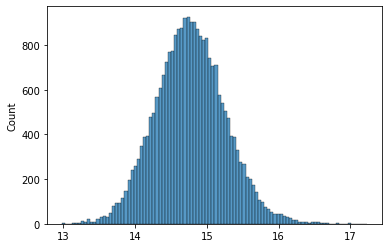

In [24]:
sns.histplot(np.linalg.norm(cls, axis=1))

/home/eecs/utrerf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/eecs/utrerf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,model_name,poisoned,embedding_flavor,source_dataset,cls_token_is_first,tokenizer_filename,embedding_filename
0,id-00000000,True,bert-base-uncased,amazon-Arts_Crafts_and_Sewing_5,True,BERT-bert-base-uncased.pt,BERT-bert-base-uncased.pt
1,id-00000001,False,gpt2,amazon-Video_Games_5,False,GPT-2-gpt2.pt,GPT-2-gpt2.pt
2,id-00000002,True,distilbert-base-uncased,amazon-Musical_Instruments_5,True,DistilBERT-distilbert-base-uncased.pt,DistilBERT-distilbert-base-uncased.pt
3,id-00000003,False,bert-base-uncased,amazon-Video_Games_5,True,BERT-bert-base-uncased.pt,BERT-bert-base-uncased.pt
4,id-00000004,True,gpt2,amazon-Musical_Instruments_5,False,GPT-2-gpt2.pt,GPT-2-gpt2.pt


In [20]:
base_path = "/scratch/data/round5-train-dataset"

metadata = pd.read_csv(os.path.join(base_path, "METADATA.csv"))
metadata.head()

commands_df = metadata[['model_name', 'poisoned', 'embedding_flavor', 'source_dataset', 'cls_token_is_first']]

embedding_flavor_to_tokenizer = {'gpt2':"GPT-2-gpt2.pt",
                                 'distilbert-base-uncased':"DistilBERT-distilbert-base-uncased.pt",
                                 'bert-base-uncased':"BERT-bert-base-uncased.pt"}
commands_df['tokenizer_filename'] = commands_df['embedding_flavor'].map(embedding_flavor_to_tokenizer)
commands_df['embedding_filename'] = commands_df['embedding_flavor'].map(embedding_flavor_to_tokenizer)
commands_df.head()

model_training_data_path = '/scratch/data/round5-train-dataset/'
text_data_path = '/scratch/data/sentiment-classification/'


commands = [f'python trojan_detector.py ' +
 f'--model_filepath {os.path.join(model_training_data_path, "models", commands_df.loc[[i]].model_name.item(), "model.pt")} ' +
 f'--cls_token_is_first {commands_df.loc[[i]].cls_token_is_first.item()} ' +
 f'--tokenizer_filepath {os.path.join(model_training_data_path, "tokenizers", commands_df.loc[[i]].tokenizer_filename.item())} ' + 
 f'--embedding_filepath {os.path.join(model_training_data_path, "embeddings", commands_df.loc[[i]].embedding_filename.item())} ' +
 f'--examples_dirpath {os.path.join(model_training_data_path, "models", commands_df.loc[[i]].model_name.item(), "clean_example_data")} ' + 
 f'--train_test train'
           for i in range(len(commands_df))]

/home/eecs/utrerf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/eecs/utrerf/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [21]:
commands

['python trojan_detector.py --model_filepath /scratch/data/round5-train-dataset/models/id-00000000/model.pt --cls_token_is_first True --tokenizer_filepath /scratch/data/round5-train-dataset/tokenizers/BERT-bert-base-uncased.pt --embedding_filepath /scratch/data/round5-train-dataset/embeddings/BERT-bert-base-uncased.pt --examples_dirpath /scratch/data/round5-train-dataset/models/id-00000000/clean_example_data --train_test train',
 'python trojan_detector.py --model_filepath /scratch/data/round5-train-dataset/models/id-00000001/model.pt --cls_token_is_first False --tokenizer_filepath /scratch/data/round5-train-dataset/tokenizers/GPT-2-gpt2.pt --embedding_filepath /scratch/data/round5-train-dataset/embeddings/GPT-2-gpt2.pt --examples_dirpath /scratch/data/round5-train-dataset/models/id-00000001/clean_example_data --train_test train',
 'python trojan_detector.py --model_filepath /scratch/data/round5-train-dataset/models/id-00000002/model.pt --cls_token_is_first True --tokenizer_filepath /s

# Check out results

In [33]:
res_lst = [os.path.join('results', x) for x in os.listdir('results')]

df_lst = []
for f in res_lst:
    temp_df = pd.read_csv(f)
    temp_df['model_name'] = re.findall(r'\/(\w+-\d+).csv', f)[0]
    df_lst.append(temp_df)
    
df = pd.concat(df_lst).reset_index(drop=True)
df = df.merge(metadata, on='model_name')
df.head()

,accuracy_2_eps_0.25,f1_2_eps_0.25,aad_2_eps_0.25,aad_std_2_eps_0.25,entropy_2_eps_0.25,kl_2_eps_0.25,accuracy_2_eps_1.0,f1_2_eps_1.0,aad_2_eps_1.0,aad_std_2_eps_1.0,...,test_wall_time_sec,final_train_acc,final_combined_val_acc,final_clean_val_acc,final_triggered_val_acc,final_clean_data_test_acc,final_triggered_data_test_acc,clean_example_acc,poisoned_example_acc,converged
0,0.558212,0.495930,0.364916,0.358212,0.408195,0.294648,0.554860,0.489334,0.360447,0.359330,...,3.202027,78.419365,81.624021,83.493442,None,83.101078,None,100.0,None,1
1,0.845772,0.845669,0.023727,0.024729,0.691924,0.001126,0.838076,0.837962,0.025571,0.026052,...,33.786261,81.109988,85.820059,85.820059,None,85.328000,None,100.0,None,1
2,0.808497,0.808304,0.037515,0.034629,0.690747,0.002817,0.806533,0.806310,0.033948,0.033948,...,29.845995,77.001418,70.471575,84.724019,None,83.874401,None,100.0,None,1
3,0.835761,0.834707,0.079420,0.079639,0.680408,0.012669,0.817319,0.816024,0.083936,0.083904,...,683.844364,95.499809,92.022184,85.814145,98.23022296151754,85.765521,98.27976582125821,100.0,100.0,1
4,0.514190,0.367691,0.480223,0.480782,0.094979,0.597094,0.524581,0.372600,0.466480,0.479330,...,3.068240,83.411490,73.866569,82.575795,None,82.712005,None,100.0,None,1


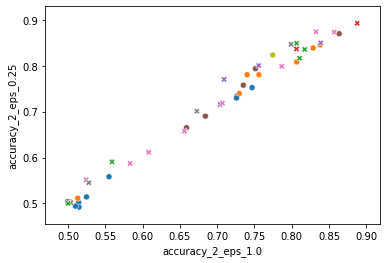

In [43]:
sns.scatterplot(data=df, y='accuracy_2_eps_0.25', x='accuracy_2_eps_1.0', 
                hue='source_dataset', style='poisoned', legend=None)

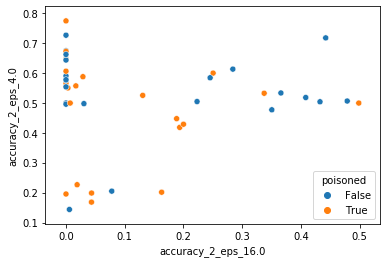

In [35]:
sns.scatterplot(data=df, y='accuracy_2_eps_4.0', x='accuracy_2_eps_16.0', hue='poisoned')